<a href="https://colab.research.google.com/github/suhailamohammed/Skin-Lesion-Classification/blob/main/Skin_Lesion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Preprocessing

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ahmedxc4/skin-ds")

print("Path to dataset files:", path)

100%|██████████| 9.25G/9.25G [01:54<00:00, 87.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedxc4/skin-ds/versions/2


In [ ]:
import shutil
import os


new_path = "/content/dataset"
os.makedirs(new_path, exist_ok=True)

shutil.copytree(path, new_path, dirs_exist_ok=True)
print("Dataset copied to:", new_path)


Dataset copied to: /content/dataset


###Transformers Initialization

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Data loader

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(root=new_path + "/train", transform=transform)
val_data = datasets.ImageFolder(root=new_path + "/val", transform=transform)
test_data = datasets.ImageFolder(root=new_path + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

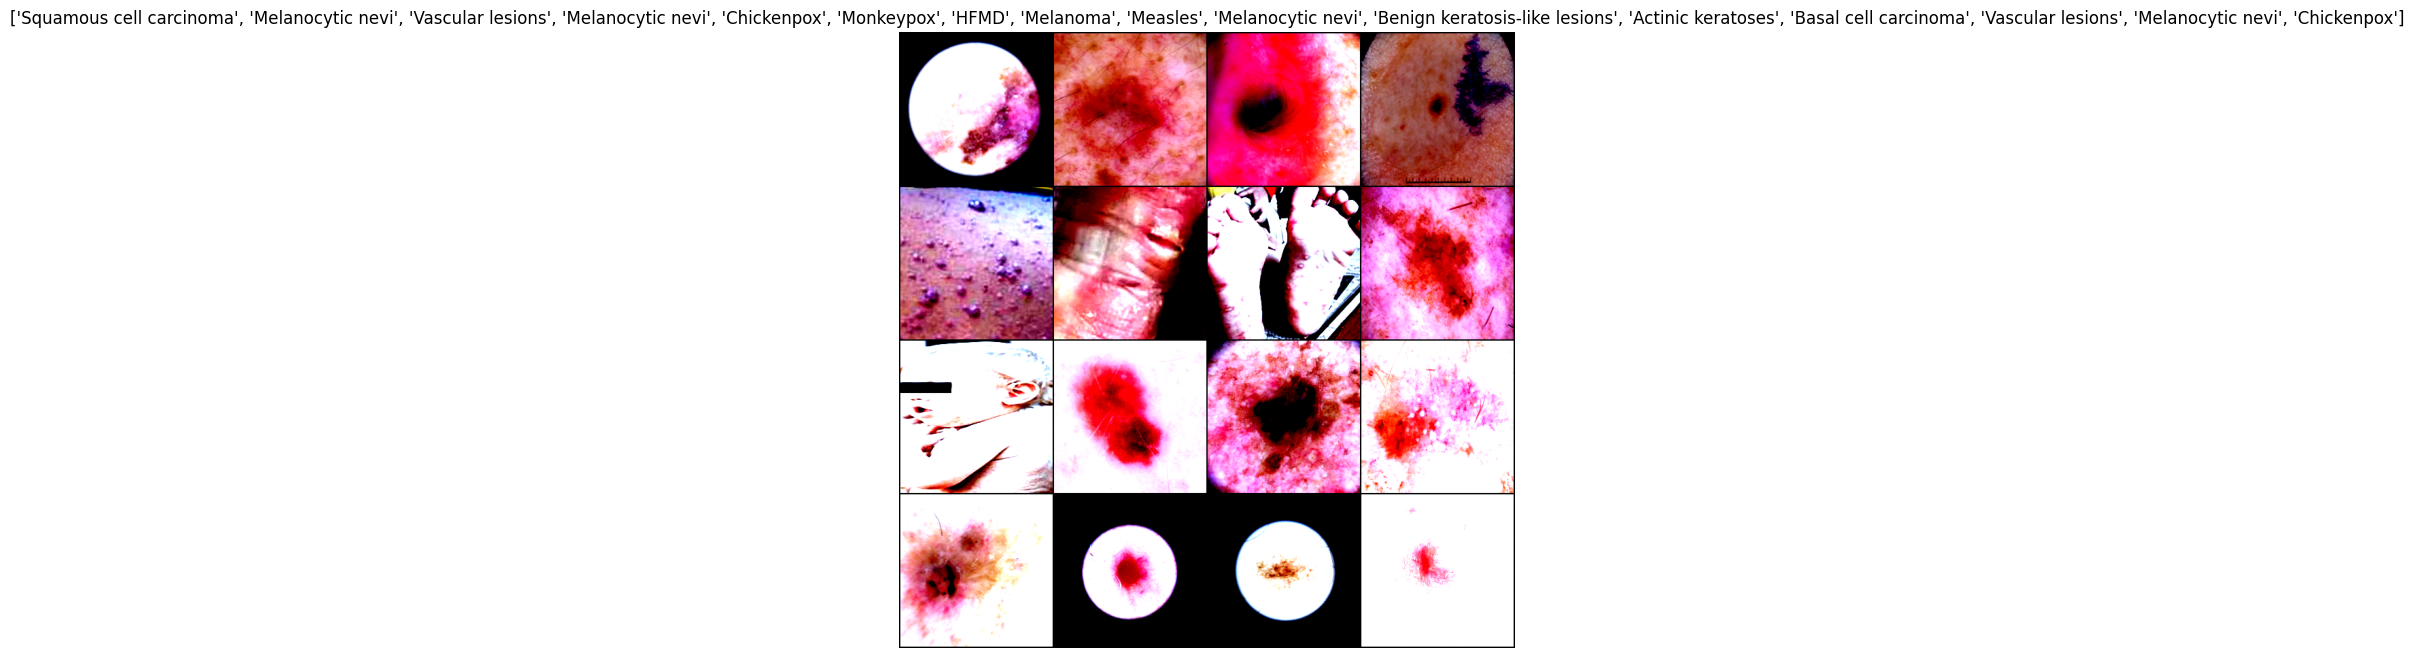

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

images, labels = next(iter(train_loader))

img_grid = torchvision.utils.make_grid(images[:16], nrow=4)

np_img = img_grid.numpy()
np_img = np.transpose(np_img, (1, 2, 0))

plt.figure(figsize=(8,8))
plt.imshow(np_img)
plt.title([train_data.classes[labels[i]] for i in range(16)])
plt.axis('off')
plt.show()


## Load pretrained CNN (ResNet)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")


In [ ]:
num_classes = len(train_data.classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

###Loss function and optimizer

In [ ]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

###Training Model

In [ ]:
best_val_acc = 0.0
epochs = 5
trainingLoss = []
validationLoss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    trainingLoss.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader):.4f}")


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        running_val_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = loss_function(outputs, labels)
            running_val_loss += loss.item()

    val_acc = correct / total
    print(f"Epoch {epoch+1}, Val Accuracy: {val_acc*100:.2f}%")
    validationLoss.append(running_val_loss / len(val_loader))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "skin_lesion_resnet18.pth")
        print("Saved new best model!")


Epoch 1, Training Loss: 0.7251
Epoch 1, Val Accuracy: 80.71%
Saved new best model!
Epoch 2, Training Loss: 0.4295
Epoch 2, Val Accuracy: 82.68%
Saved new best model!
Epoch 3, Training Loss: 0.2636
Epoch 3, Val Accuracy: 83.47%
Saved new best model!
Epoch 4, Training Loss: 0.1529
Epoch 4, Val Accuracy: 84.78%
Saved new best model!
Epoch 5, Training Loss: 0.0980
Epoch 5, Val Accuracy: 84.95%
Saved new best model!


## Testing model

In [ ]:
model.load_state_dict(torch.load("skin_lesion_resnet18.pth"))
model.to(device)
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 83.45%


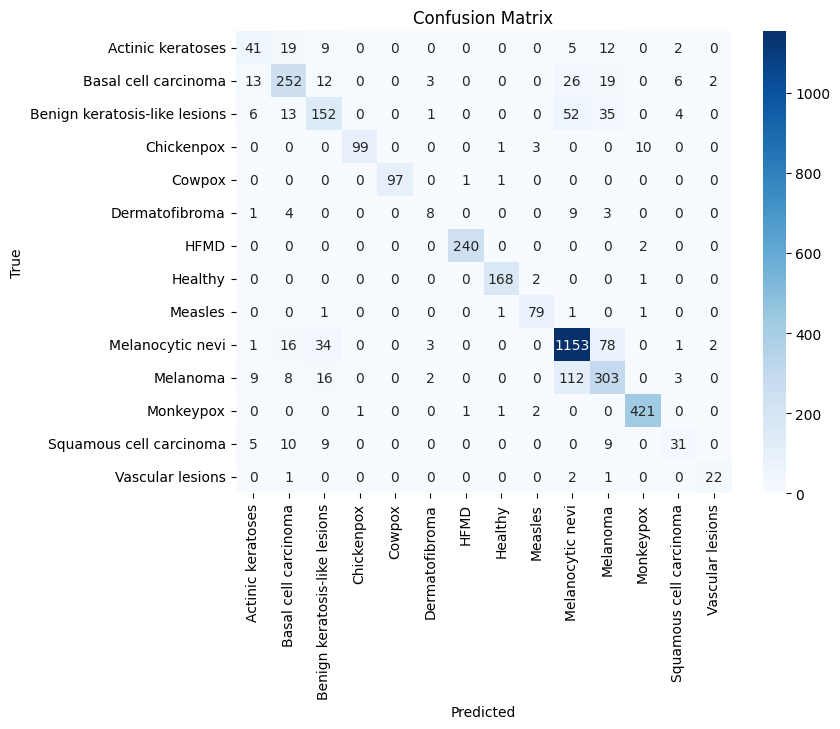

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


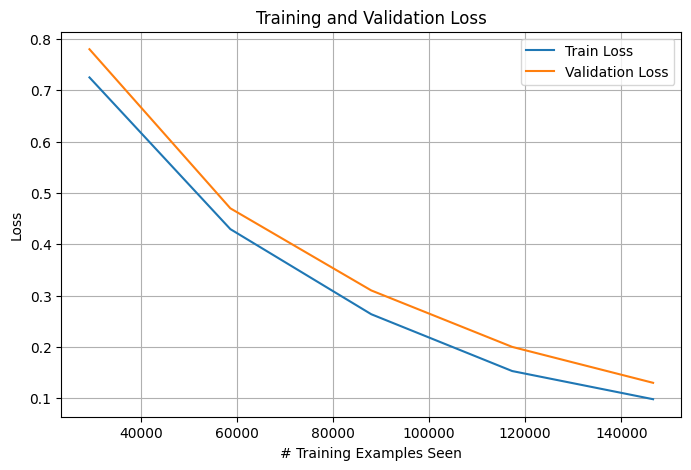

In [ ]:
numOfTrainingExamplesSeen = [len(train_loader.dataset) * (epoch + 1) for epoch in range(epochs)]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(numOfTrainingExamplesSeen, trainingLoss, label='Train Loss')
ax.plot(numOfTrainingExamplesSeen, validationLoss, label='Validation Loss')
ax.set_xlabel('# Training Examples Seen')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True)
plt.show()
